# Comparison of Geometry and Temperature Dependence of Drift-driven Acoplanarity Enhancement for 5.02 TeV PbPb collision at LHC Vs 200 GeV AuAu collision at RHIC

In [1]:
import os
import sys
#import hic
#import utilities
import pandas as pd
import numpy as np
import xarray as xr
#import plasma
#import plasma_interaction as pi
#import jets
#import config
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.interpolate as interpolate
import numpy.random as rn
from scipy import integrate
from scipy.interpolate import RegularGridInterpolator
from scipy.special import expi

import scipy.optimize as optimize
import fnmatch
# import lhapdf

%matplotlib inline
%config InlineBackend.figure_format='png'
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'Helvetica'

# Load APE data for PbPb and AuAu with limited columns

In [2]:
# Create an empty dataframe to store this stuff
pbpb = pd.DataFrame({})

# Choose how many files to load
num_files = 5

# Select the columns to load -- here you will specify the data to work with
p_cols = ['pt_f', 'mult', 'drift', 'cel', 'seed', 'pt_0', 'e2', 'e3', 'e4', 'b', 'psi_e2', 'psi_e3', 'psi_e4', 'weight', 'npart', 'urqmd_dNch_deta',
          'phi_0', 'phi_f', 'psi_2', 'AA_weight', 'hadron_pt_0', 'hadron_pt_f', 'aco', 'urqmd_re_q_2', 'urqmd_im_q_2', 'urqmd_flow_N',
          'urqmd_re_q_3', 'urqmd_im_q_3', 'urqmd_re_q_4', 'urqmd_im_q_4', 'K_F_DRIFT', 'Tmax_event', 'process', 'process_run']

# Select the directory with the data files
directory = '/fs1/project/sievert_nt/ape_data/drift_letter/v1.1.0'

# List all the parton files in there
data_files = np.array(os.listdir(directory))
p_files = fnmatch.filter(data_files, '*partons*.parquet')
print(directory)
print('{} parton files'.format(len(p_files)))

# Iterate through files, loading desired data
i = 0
try:
    for file in p_files[0:num_files]:
        print('loading files ... {}%'.format(i*100/len(p_files)))
        try:
            loaded_df = pd.read_parquet(directory + '/' + file, columns=p_cols)  # load file
            pbpb = pd.concat([pbpb, loaded_df], axis=0)  # concatenate to the dataframe
        except ValueError:
            print('empty file')
        try:
            loaded_events = int(len(pbpb['seed'].value_counts()))
            print('Loaded ~{} events'.format(loaded_events))
        except:
            pass
        i += 1
except Exception as error:
    # handle the exception and print what happened
    print("An exception occurred:", type(error).__name__, "–", error)

# Tell me how many we loaded
print('Loaded {} files'.format(i))

/fs1/project/sievert_nt/ape_data/drift_letter/v1.1.0
20 parton files
loading files ... 0.0%
Loaded ~500 events
loading files ... 5.0%
Loaded ~1000 events
loading files ... 10.0%
Loaded ~1500 events
loading files ... 15.0%
Loaded ~2000 events
loading files ... 20.0%
Loaded ~2500 events
Loaded 5 files


In [3]:
pbpb

,pt_f,mult,drift,cel,seed,pt_0,e2,e3,e4,b,...,urqmd_im_q_2,urqmd_flow_N,urqmd_re_q_3,urqmd_im_q_3,urqmd_re_q_4,urqmd_im_q_4,K_F_DRIFT,Tmax_event,process,process_run
0,52.193459,28.946748,False,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,-718.644888,24852,326.568553,134.415756,-19.242067,-107.622136,0.00,0.312134,652966229541,0
0,52.546942,28.946748,False,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,-718.644888,24852,326.568553,134.415756,-19.242067,-107.622136,0.00,0.312134,652966229541,0
0,52.193469,28.946748,True,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,-718.644888,24852,326.568553,134.415756,-19.242067,-107.622136,1.00,0.312134,652966229541,1
0,52.546939,28.946748,True,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,-718.644888,24852,326.568553,134.415756,-19.242067,-107.622136,1.00,0.312134,652966229541,1
0,52.193466,28.946748,True,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,-718.644888,24852,326.568553,134.415756,-19.242067,-107.622136,0.75,0.312134,652966229541,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,65.805056,268.589546,True,True,9827449122834642,65.862754,0.691333,0.371648,0.707712,12.483316,...,1164.778426,26329,325.271927,-903.038712,599.892522,419.974520,1.00,0.466711,97457703322,85
0,58.546029,268.589546,True,True,9827449122834642,65.862754,0.691333,0.371648,0.707712,12.483316,...,1164.778426,26329,325.271927,-903.038712,599.892522,419.974520,0.75,0.466711,97457703322,86
0,65.805056,268.589546,True,True,9827449122834642,65.862754,0.691333,0.371648,0.707712,12.483316,...,1164.778426,26329,325.271927,-903.038712,599.892522,419.974520,0.75,0.466711,97457703322,86
0,58.545990,268.589546,True,True,9827449122834642,65.862754,0.691333,0.371648,0.707712,12.483316,...,1164.778426,26329,325.271927,-903.038712,599.892522,419.974520,1.25,0.466711,97457703322,87


In [4]:
######################
# Centrality Binning #
######################
'''
Binning the data according to multiplicity bins to mimic experimental "centrality".
'''
print('Binning by centrality')
# Bin by centrality using percentile bounds on multiplicity
# Create percentile bounds using partonic data
# -- partonic data should have constant number of entries per event, so
# -- no need for craziness
# Apply label series to each entry

df = pbpb

cent_bins = np.array(['90-100', '80-90', '70-80', '60-70', '50-60',
                      '40-50', '30-40', '20-30', '10-20', '0-10'])
q_bins = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# cent_bins = np.array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', 
#                       '60-70', '70-80', '80-90', '90-100'])
# q_bins = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])

cents, mult_bins = pd.qcut(df['mult'], q=q_bins, labels=cent_bins, retbins=True)
df['cent'] = cents
print('done')
# def = aco
# df = v2_df

Binning by centrality
done


In [5]:
pbpb

,pt_f,mult,drift,cel,seed,pt_0,e2,e3,e4,b,...,urqmd_flow_N,urqmd_re_q_3,urqmd_im_q_3,urqmd_re_q_4,urqmd_im_q_4,K_F_DRIFT,Tmax_event,process,process_run,cent
0,52.193459,28.946748,False,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,24852,326.568553,134.415756,-19.242067,-107.622136,0.00,0.312134,652966229541,0,70-80
0,52.546942,28.946748,False,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,24852,326.568553,134.415756,-19.242067,-107.622136,0.00,0.312134,652966229541,0,70-80
0,52.193469,28.946748,True,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,24852,326.568553,134.415756,-19.242067,-107.622136,1.00,0.312134,652966229541,1,70-80
0,52.546939,28.946748,True,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,24852,326.568553,134.415756,-19.242067,-107.622136,1.00,0.312134,652966229541,1,70-80
0,52.193466,28.946748,True,False,4719398702523147,53.758450,0.651088,0.434317,0.360005,15.343934,...,24852,326.568553,134.415756,-19.242067,-107.622136,0.75,0.312134,652966229541,2,70-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,65.805056,268.589546,True,True,9827449122834642,65.862754,0.691333,0.371648,0.707712,12.483316,...,26329,325.271927,-903.038712,599.892522,419.974520,1.00,0.466711,97457703322,85,50-60
0,58.546029,268.589546,True,True,9827449122834642,65.862754,0.691333,0.371648,0.707712,12.483316,...,26329,325.271927,-903.038712,599.892522,419.974520,0.75,0.466711,97457703322,86,50-60
0,65.805056,268.589546,True,True,9827449122834642,65.862754,0.691333,0.371648,0.707712,12.483316,...,26329,325.271927,-903.038712,599.892522,419.974520,0.75,0.466711,97457703322,86,50-60
0,58.545990,268.589546,True,True,9827449122834642,65.862754,0.691333,0.371648,0.707712,12.483316,...,26329,325.271927,-903.038712,599.892522,419.974520,1.25,0.466711,97457703322,87,50-60


In [ ]:
# pbpb.to_parquet('PbPb_LHC_5.02TeV_acoplanarities_newdata_v1.1.0.parquet')

In [15]:
# Create an empty dataframe to store this stuff
auau = pd.DataFrame({})

# Choose how many files to load
num_files = 10

# Select the columns to load -- here you will specify the data to work with
p_cols = ['pt_f', 'mult', 'drift', 'cel', 'seed', 'pt_0', 'e2', 'e3', 'e4', 'b', 'psi_e2', 'psi_e3', 'psi_e4', 'weight', 'npart', 'urqmd_dNch_deta',
          'phi_0', 'phi_f', 'psi_2', 'AA_weight', 'hadron_pt_0', 'hadron_pt_f', 'aco', 'urqmd_re_q_2', 'urqmd_im_q_2', 'urqmd_flow_N',
          'urqmd_re_q_3', 'urqmd_im_q_3', 'urqmd_re_q_4', 'urqmd_im_q_4', 'K_F_DRIFT', 'Tmax_event', 'process', 'process_run']

# Select the directory with the data files
directory = "/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.3_g_rad=2.2_g_col=2.0"

# List all the parton files in there
data_files = np.array(os.listdir(directory))
p_files = fnmatch.filter(data_files, '*partons*.parquet')
print(directory)
print('{} parton files'.format(len(p_files)))

# Iterate through files, loading desired data
i = 0
try:
    for file in p_files[0:num_files]:
        print('loading files ... {}%'.format(i*100/len(p_files)))
        try:
            loaded_df = pd.read_parquet(directory + '/' + file, columns=p_cols)  # load file
            auau = pd.concat([auau, loaded_df], axis=0)  # concatenate to the dataframe
        except ValueError:
            print('empty file')
        try:
            loaded_events = int(len(auau['seed'].value_counts()))
            print('Loaded ~{} events'.format(loaded_events))
        except:
            pass
        i += 1
except Exception as error:
    # handle the exception and print what happened
    print("An exception occurred:", type(error).__name__, "–", error)

# Tell me how many we loaded
print('Loaded {} files'.format(i))

/fs1/project/sievert_nt/ape_data/hasan/RHIC_AuAu_hasan_v1.0.3_g_rad=2.2_g_col=2.0
10 parton files
loading files ... 0.0%
Loaded ~100 events
loading files ... 10.0%
Loaded ~200 events
loading files ... 20.0%
Loaded ~254 events
loading files ... 30.0%
Loaded ~354 events
loading files ... 40.0%
Loaded ~454 events
loading files ... 50.0%
Loaded ~554 events
loading files ... 60.0%
Loaded ~654 events
loading files ... 70.0%
Loaded ~754 events
loading files ... 80.0%
Loaded ~854 events
loading files ... 90.0%
Loaded ~954 events
Loaded 10 files


In [16]:
auau

,pt_f,mult,drift,cel,seed,pt_0,e2,e3,e4,b,...,urqmd_im_q_2,urqmd_flow_N,urqmd_re_q_3,urqmd_im_q_3,urqmd_re_q_4,urqmd_im_q_4,K_F_DRIFT,Tmax_event,process,process_run
0,14.314564,95.673202,False,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,1370.193794,25267,-444.547087,291.847372,-154.299056,388.419232,0.00,0.381640,430900478033,0
0,17.009992,95.673202,False,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,1370.193794,25267,-444.547087,291.847372,-154.299056,388.419232,0.00,0.381640,430900478033,0
0,14.316341,95.673202,True,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,1370.193794,25267,-444.547087,291.847372,-154.299056,388.419232,1.00,0.381640,430900478033,1
0,17.010029,95.673202,True,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,1370.193794,25267,-444.547087,291.847372,-154.299056,388.419232,1.00,0.381640,430900478033,1
0,14.315892,95.673202,True,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,1370.193794,25267,-444.547087,291.847372,-154.299056,388.419232,0.75,0.381640,430900478033,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3.522446,125.802981,True,True,6859166753038184,6.462290,0.588370,0.081710,0.243509,11.338360,...,21.855427,25066,-520.610400,63.471134,365.956735,-108.191737,1.00,0.387771,799427372349,85
0,5.334426,125.802981,True,True,6859166753038184,6.462290,0.588370,0.081710,0.243509,11.338360,...,21.855427,25066,-520.610400,63.471134,365.956735,-108.191737,0.75,0.387771,799427372349,86
0,3.522518,125.802981,True,True,6859166753038184,6.462290,0.588370,0.081710,0.243509,11.338360,...,21.855427,25066,-520.610400,63.471134,365.956735,-108.191737,0.75,0.387771,799427372349,86
0,5.334700,125.802981,True,True,6859166753038184,6.462290,0.588370,0.081710,0.243509,11.338360,...,21.855427,25066,-520.610400,63.471134,365.956735,-108.191737,1.25,0.387771,799427372349,87


In [17]:
######################
# Centrality Binning #
######################
'''
Binning the data according to multiplicity bins to mimic experimental "centrality".
'''
print('Binning by centrality')
# Bin by centrality using percentile bounds on multiplicity
# Create percentile bounds using partonic data
# -- partonic data should have constant number of entries per event, so
# -- no need for craziness
# Apply label series to each entry

df = auau

cent_bins = np.array(['90-100', '80-90', '70-80', '60-70', '50-60',
                      '40-50', '30-40', '20-30', '10-20', '0-10'])
q_bins = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# cent_bins = np.array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', 
#                       '60-70', '70-80', '80-90', '90-100'])
# q_bins = np.array([1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0])

cents, mult_bins = pd.qcut(df['mult'], q=q_bins, labels=cent_bins, retbins=True)
df['cent'] = cents
print('done')
# def = aco
# df = v2_df

Binning by centrality
done


In [18]:
auau

,pt_f,mult,drift,cel,seed,pt_0,e2,e3,e4,b,...,urqmd_flow_N,urqmd_re_q_3,urqmd_im_q_3,urqmd_re_q_4,urqmd_im_q_4,K_F_DRIFT,Tmax_event,process,process_run,cent
0,14.314564,95.673202,False,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,25267,-444.547087,291.847372,-154.299056,388.419232,0.00,0.381640,430900478033,0,50-60
0,17.009992,95.673202,False,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,25267,-444.547087,291.847372,-154.299056,388.419232,0.00,0.381640,430900478033,0,50-60
0,14.316341,95.673202,True,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,25267,-444.547087,291.847372,-154.299056,388.419232,1.00,0.381640,430900478033,1,50-60
0,17.010029,95.673202,True,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,25267,-444.547087,291.847372,-154.299056,388.419232,1.00,0.381640,430900478033,1,50-60
0,14.315892,95.673202,True,False,8017379358176321,17.338577,0.762694,0.539171,0.773367,11.859364,...,25267,-444.547087,291.847372,-154.299056,388.419232,0.75,0.381640,430900478033,2,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3.522446,125.802981,True,True,6859166753038184,6.462290,0.588370,0.081710,0.243509,11.338360,...,25066,-520.610400,63.471134,365.956735,-108.191737,1.00,0.387771,799427372349,85,40-50
0,5.334426,125.802981,True,True,6859166753038184,6.462290,0.588370,0.081710,0.243509,11.338360,...,25066,-520.610400,63.471134,365.956735,-108.191737,0.75,0.387771,799427372349,86,40-50
0,3.522518,125.802981,True,True,6859166753038184,6.462290,0.588370,0.081710,0.243509,11.338360,...,25066,-520.610400,63.471134,365.956735,-108.191737,0.75,0.387771,799427372349,86,40-50
0,5.334700,125.802981,True,True,6859166753038184,6.462290,0.588370,0.081710,0.243509,11.338360,...,25066,-520.610400,63.471134,365.956735,-108.191737,1.25,0.387771,799427372349,87,40-50


In [19]:
# auau.to_parquet('AuAu_RHIC_200GeV_acoplanarities_newdata_v1.0.3.parquet')

## Acoplanarity Selection Cuts

<Axes: >

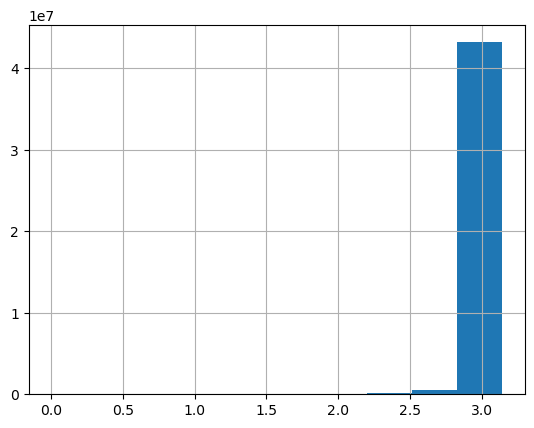

In [20]:
pbpb['aco'].hist()

In [21]:
pbpb['K_F_DRIFT'].value_counts()

0.00    11000000
1.00    11000000
0.75    11000000
1.25    11000000
Name: K_F_DRIFT, dtype: int64

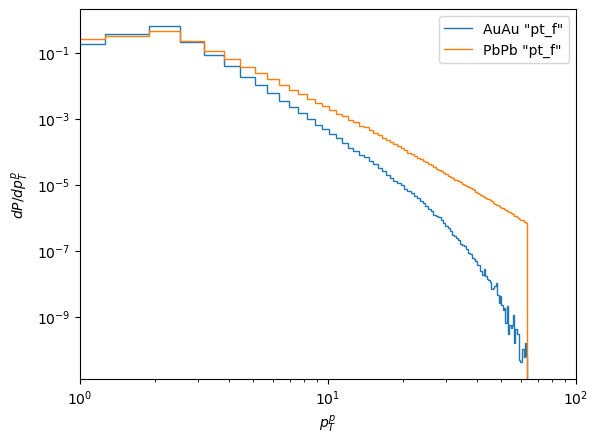

In [22]:
# Create a figure
fig, axis = plt.subplots()
axis.set_xscale("log")
axis.set_yscale("log")
axis.set_xlabel(r"$p_T^p$")
axis.set_ylabel(r"$dP/dp_T^p$")
axis.set_xlim(1, 100)

# Choose some plot options
hist_bins = 100
density_bool = True
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Choose cases you want to load
auau_mask = (auau["cel"] == False) & (auau["K_F_DRIFT"] == 1.0)
pbpb_mask = (pbpb["cel"] == False) & (pbpb["K_F_DRIFT"] == 1.0)

# Choose what to histogram
hist_series = "pt_f"
weight_series = "weight"

# Compute some histograms
auau_counts, bins = np.histogram(auau[auau_mask][hist_series], density=density_bool, weights=auau[auau_mask][weight_series], bins=hist_bins)
pbpb_counts, bins = np.histogram(pbpb[pbpb_mask][hist_series], density=density_bool, weights=pbpb[pbpb_mask][weight_series], bins=bins)
bin_cents = (bins[0:-1] + bins[1:])/2
bin_widths = (bins[1:] - bins[0:-1])

# Plot the histogram data as stairs plots
# Note that we feed like plt.stairs(<bin edges>, <values>), which is reversed from plt.plot() or something
axis.stairs(auau_counts, bins, label=f"AuAu \"{hist_series}\"", fill=False, edgecolor=colors[0])
axis.stairs(pbpb_counts, bins, label=f"PbPb \"{hist_series}\"", fill=False, edgecolor=colors[1])

# Create a legend
axis.legend()
plt.savefig("hist_pt_f_5.02TeVPbPbLHC_vs_200GeVAuAuRHIC.png", bbox_inches="tight")

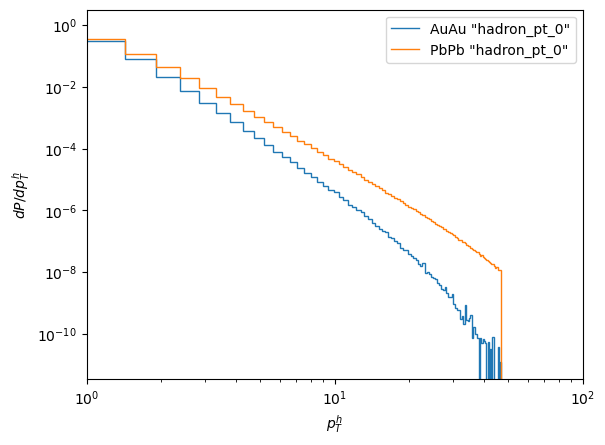

In [23]:
# Create a figure
fig, axis = plt.subplots()
axis.set_xscale("log")
axis.set_yscale("log")
axis.set_xlabel(r"$p_T^h$")
axis.set_ylabel(r"$dP/dp_T^h$")
axis.set_xlim(1, 100)

# Choose some plot options
hist_bins = 100
density_bool = True
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Choose cases you want to load
auau_mask = (auau["cel"] == False) & (auau["K_F_DRIFT"] == 1.0)
pbpb_mask = (pbpb["cel"] == False) & (pbpb["K_F_DRIFT"] == 1.0)

# Choose what to histogram
hist_series = "hadron_pt_0"
weight_series = "weight"

# Compute some histograms
auau_counts, bins = np.histogram(auau[auau_mask][hist_series], density=density_bool, weights=auau[auau_mask][weight_series], bins=hist_bins)
pbpb_counts, bins = np.histogram(pbpb[pbpb_mask][hist_series], density=density_bool, weights=pbpb[pbpb_mask][weight_series], bins=bins)
bin_cents = (bins[0:-1] + bins[1:])/2
bin_widths = (bins[1:] - bins[0:-1])

# Plot the histogram data as stairs plots
# Note that we feed like plt.stairs(<bin edges>, <values>), which is reversed from plt.plot() or something
axis.stairs(auau_counts, bins, label=f"AuAu \"{hist_series}\"", fill=False, edgecolor=colors[0])
axis.stairs(pbpb_counts, bins, label=f"PbPb \"{hist_series}\"", fill=False, edgecolor=colors[1])

# Create a legend
axis.legend()
# plt.savefig("hist_pt_0_5.02TeVPbPbLHC_vs_200GeVAuAuRHIC.png", bbox_inches="tight")

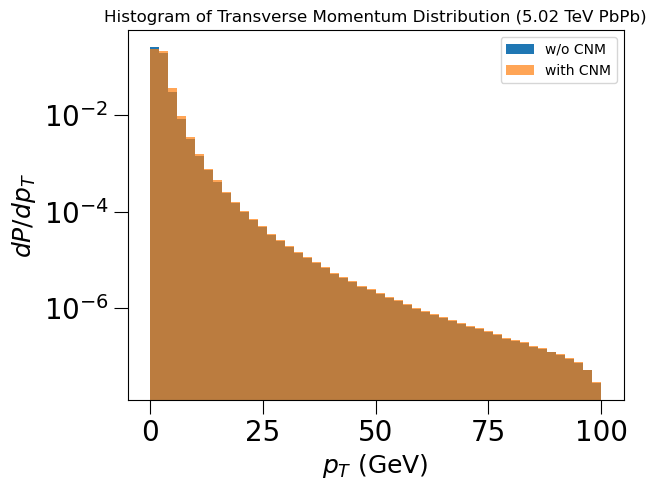

In [34]:
#p-T distribution of partons

fig, axis = plt.subplots(1)
axis.set_title(r'Histogram of Transverse Momentum Distribution (5.02 TeV PbPb)', fontsize= 12) #^{hard}

plt.hist(pbpb['pt_f'], weights=pbpb['weight'], bins=50, density=True, label='w/o CNM')  #[results['K_F_DRIFT'] == 0.75] #w/o CNM effect
plt.hist(pbpb['pt_f'], weights=pbpb['AA_weight'], bins=50, density=True, label='with CNM', alpha=0.7)  #[results['K_F_DRIFT'] == 0.75] #with CNM effect

plt.xlabel(r'$p_T$ (GeV)', fontsize= 18)
plt.ylabel(r'$dP/dp_T$', fontsize= 18)
axis.tick_params(axis='both',which='major',labelsize=20,length=10)
plt.yscale('log')
plt.legend()
# plt.savefig("hist_pt_full_weighted_CNM_vs_wo_PbPb_5.02TeV_v1.1.0.png", bbox_inches="tight")
# plt.xlim(0,0.6)
# plt.ylim(1e-10,1)

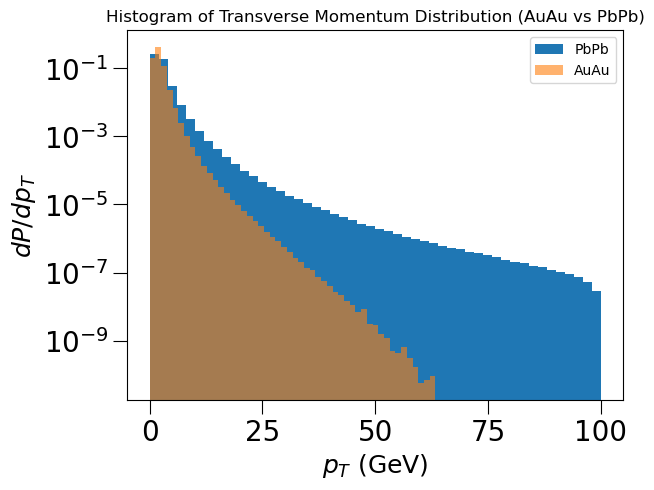

In [65]:
#p-T distribution of partons

fig, axis = plt.subplots(1)
axis.set_title(r'Histogram of Transverse Momentum Distribution (AuAu vs PbPb)', fontsize= 12) #^{hard}

plt.hist(pbpb['pt_f'], weights=pbpb['weight'], bins=50, density=True, label='PbPb') #[results['K_F_DRIFT'] == 0.75] 
plt.hist(auau['pt_f'], weights=auau['weight'], bins=50, density=True, alpha=0.6, label='AuAu') #[results['K_F_DRIFT'] == 0.75] 

plt.xlabel(r'$p_T$ (GeV)', fontsize= 18)
plt.ylabel(r'$dP/dp_T$', fontsize= 18)
axis.tick_params(axis='both',which='major',labelsize=20,length=10)
plt.yscale('log')
# plt.xlim(0,0.6)
# plt.ylim(1e-10,1)
plt.legend()
plt.savefig("hist_pt_full_weighted__AuAu_200GeV_vs_PbPb_5.02TeV.png", bbox_inches="tight")

4.9673747801006565
2.13482047407941


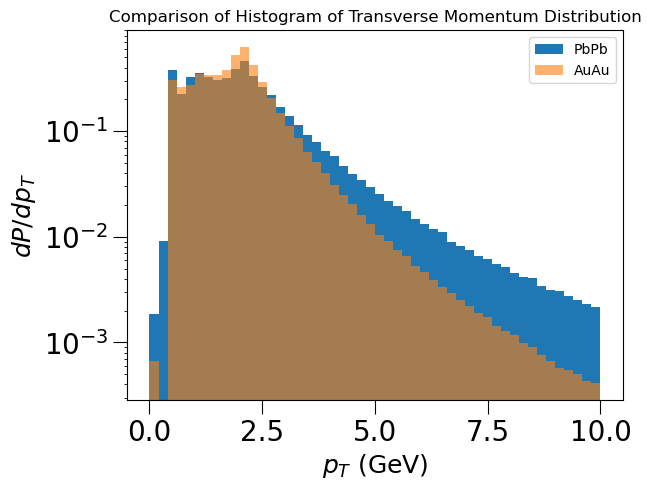

In [66]:
#p-T distribution of partons

print(np.mean(pbpb[pbpb['pt_f'] < 10]['pt_f'])) #without adding weights
print(np.average(pbpb[pbpb["pt_f"] < 10]["pt_f"], weights=pbpb[pbpb["pt_f"] < 10]["weight"])) #after adding weights

fig, axis = plt.subplots(1)
axis.set_title(r'Comparison of Histogram of Transverse Momentum Distribution', fontsize= 12) #^{hard}

plt.hist(pbpb[pbpb['pt_f'] < 10]['pt_f'], weights=pbpb[pbpb["pt_f"] < 10]["weight"], bins=50, density=True, label='PbPb') #[results['K_F_DRIFT'] == 0.75] #PbPb
plt.hist(auau[auau['pt_f'] < 10]['pt_f'], bins=50, density=True, weights=auau[auau["pt_f"] < 10]["weight"], alpha=0.6, label='AuAu') #[results['K_F_DRIFT'] == 0.75] #AuAu

plt.xlabel(r'$p_T$ (GeV)', fontsize= 18)
plt.ylabel(r'$dP/dp_T$', fontsize= 18)
axis.tick_params(axis='both',which='major',labelsize=20,length=10)
plt.yscale('log')
plt.legend()
plt.savefig("hist_pt<10_full_weighted__AuAu_200GeV_vs_PbPb_5.02TeV.png", bbox_inches="tight")
# plt.xlim(0,0.6)
# plt.ylim(1e-10,1)

Text(0, 0.5, 'Acoplanarity (rad)')

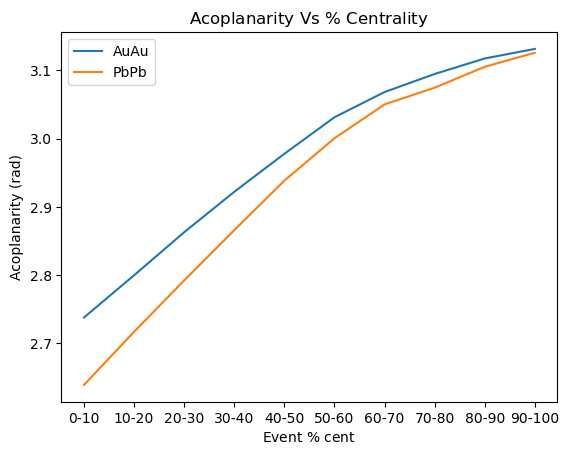

In [45]:
#Aco Vs %cent
cent_labels = np.array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])

val_arraypbpb = np.array([])
val_arrayauau = np.array([])

for cent in cent_labels:
    df = pbpb[(pbpb['cent'] == cent)] #& (results['K_F_DRIFT'] == 0.75)]
    val = np.average(df['aco'] , weights=df['weight'])
    val_arraypbpb = np.append(val_arraypbpb, val)
    # do stuff
    #print('{}% : b= {}'.format(cent_10, val))

for cent in cent_labels:
    df = auau[(auau['cent'] == cent)] #& (results['K_F_DRIFT'] == 0.75)]
    val = np.average(df['aco'] , weights=df['weight'])
    val_arrayauau = np.append(val_arrayauau, val)

fig, axis = plt.subplots(1)
axis.plot(cent_labels, val_arrayauau, label ='AuAu')
axis.plot(cent_labels, val_arraypbpb, label = 'PbPb')

plt.legend()

axis.set_title(r'Acoplanarity Vs $\%$ Centrality')
axis.set_xlabel('Event $\%$ cent')
axis.set_ylabel('Acoplanarity (rad)')

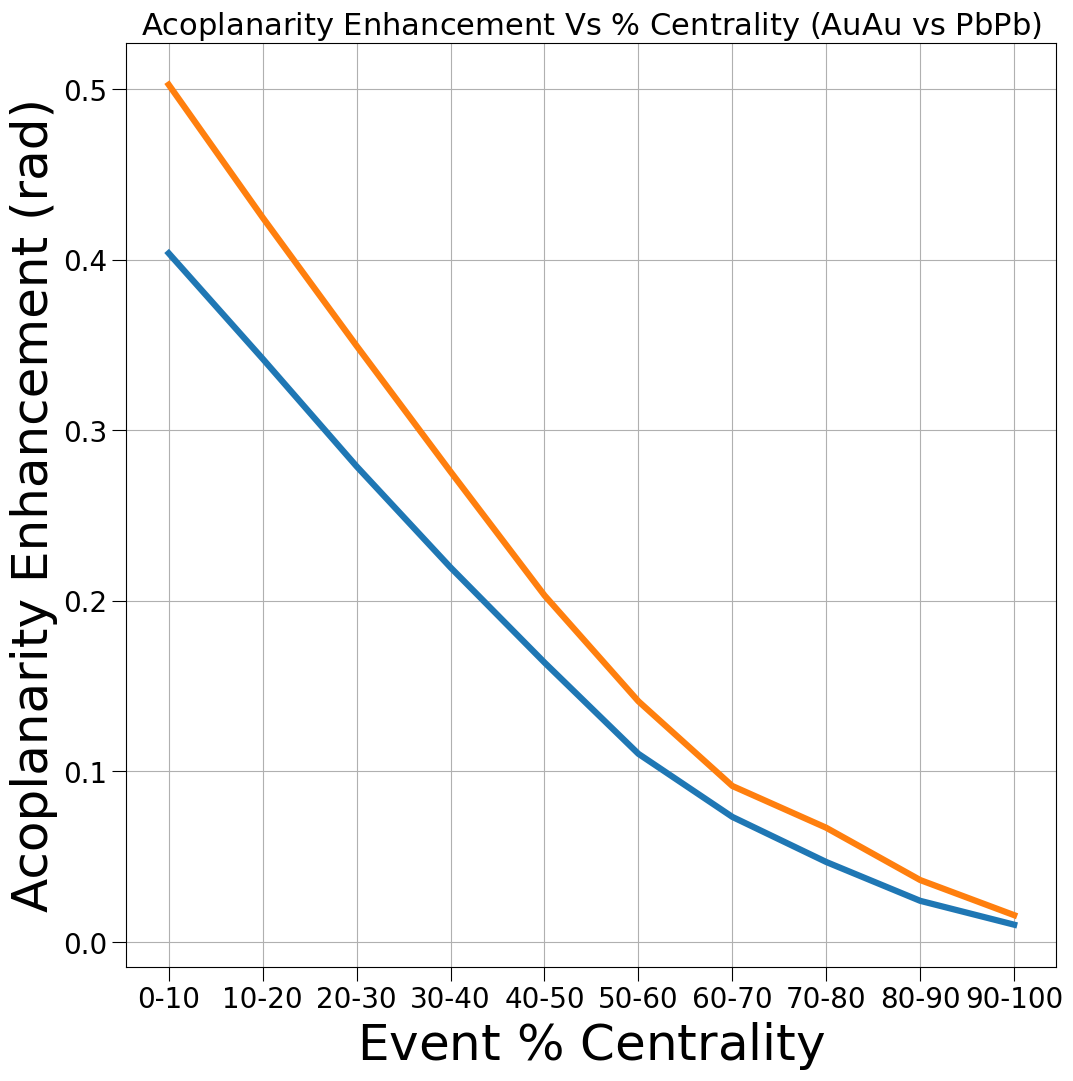

In [48]:
#Acoplanarity = func(%cent) Plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_title(r'Acoplanarity Enhancement Vs $\%$ Centrality (AuAu vs PbPb)', fontsize= 22)
ax.set_xlabel('Event $\%$ Centrality', fontsize= 36)
ax.set_ylabel('Acoplanarity Enhancement (rad)', fontsize= 36)

ax.plot(cent_labels, np.pi-val_arrayauau, linewidth = 4.5, label = 'AuAu')
ax.plot(cent_labels, np.pi-val_arraypbpb, linewidth = 4.5, label = 'PbPb')

ax.tick_params(axis='both',which='major',labelsize=20,length=10)
# plt.ylim(0,0.08)
ax.grid()
# ax.legend(fontsize=24)
# plt.savefig("aco_enh_weighted_func_%cent_PbPb_LHC_5.02TeV_vs_AuAu_RHIC_200GeV_v1.1.0.png", bbox_inches="tight")
# ax.set_xlim(0,500)
# print(T_bins, values)

0-5% : b= nan
5-10% : b= nan
10-20% : b= 6.1806148814747335
20-30% : b= 8.1861157331625
30-40% : b= 9.596921280490527
40-50% : b= 10.83034801612708
50-60% : b= 11.933121507196837
60-70% : b= 12.781039037431578
70-80% : b= 13.858394947955205
80-90% : b= 14.50383973112841
90-100% : b= 15.43645265124688
0-5% : b= nan
5-10% : b= nan
10-20% : b= 6.633755898334798
20-30% : b= 8.635928621599998
30-40% : b= 10.206037291396004
40-50% : b= 11.569778210332398
50-60% : b= 12.7639610004896
60-70% : b= 13.754600545021585
70-80% : b= 14.771713709158409
80-90% : b= 15.603670414509986
90-100% : b= 16.22180181002559


Text(0, 0.5, 'b')

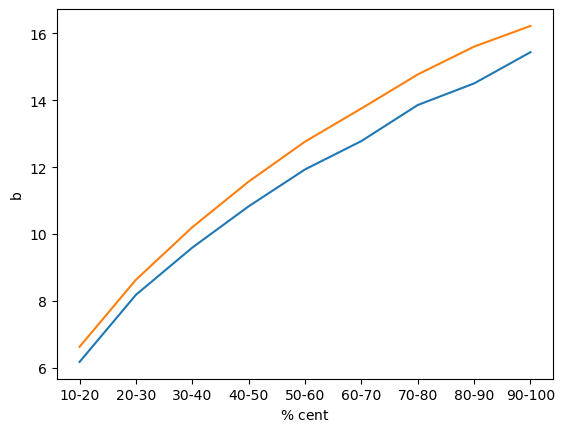

In [49]:
cent_labels = np.array(['0-5', '5-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])

b_arrayauau = np.array([])
b_arraypbpb = np.array([])

for cent in cent_labels:
    df = auau[auau['cent'] == cent]
    val = np.mean(df['b'])
    b_arrayauau = np.append(b_arrayauau, val)
    # do stuff
    print('{}% : b= {}'.format(cent, val))

for cent in cent_labels:
    df = pbpb[pbpb['cent'] == cent]
    val = np.mean(df['b'])
    b_arraypbpb = np.append(b_arraypbpb, val)
    # do stuff
    print('{}% : b= {}'.format(cent, val))

fig, axis = plt.subplots(1)
axis.plot(cent_labels, b_arrayauau, label = 'AuAu')
axis.plot(cent_labels, b_arraypbpb, label = 'PbPb')

# plt.plot(cent_labels, val_array)
# axis.set_title(r'Event {} % cent'.format(cent_bin))
axis.set_xlabel('$\%$ cent')
axis.set_ylabel('b')


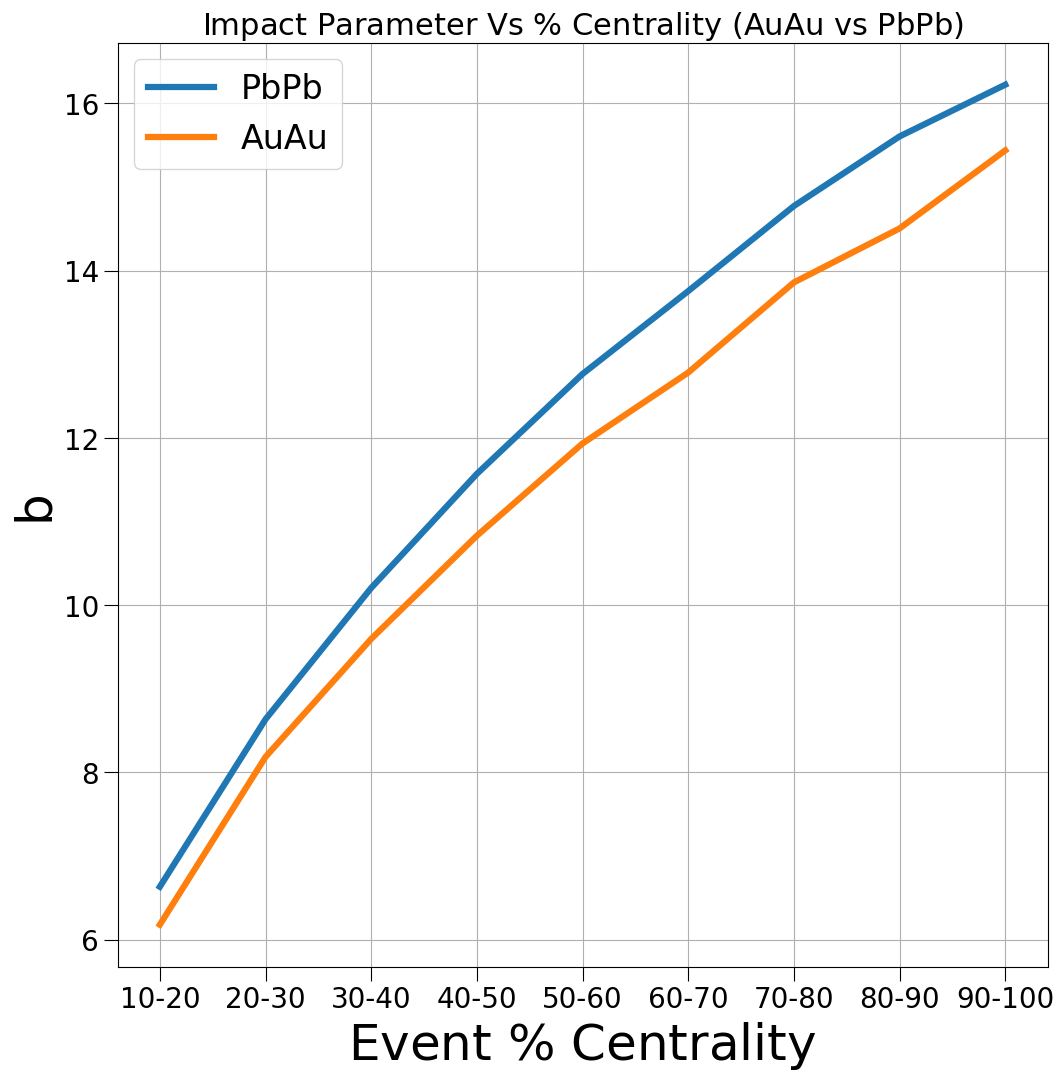

In [52]:
#Impact Parameter = func(%cent) Plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_title(r'Impact Parameter Vs $\%$ Centrality (AuAu vs PbPb)', fontsize= 22)
ax.set_xlabel('Event $\%$ Centrality', fontsize= 36)
ax.set_ylabel('b', fontsize= 36)

ax.plot(cent_labels, b_arraypbpb, linewidth = 4.5, label= 'PbPb')
ax.plot(cent_labels, b_arrayauau, linewidth = 4.5, label= 'AuAu') #, label="$T = 0 - 1$ GeV" , color='g'

ax.tick_params(axis='both',which='major',labelsize=20,length=10)
# plt.ylim(0,0.08)
ax.grid()
ax.legend(fontsize=24)
# plt.savefig("b_func_%cent_PbPb_LHC_5.02TeV_vs_AuAu_RHIC_200GeV_v1.1.0.png", bbox_inches="tight")
# ax.set_xlim(0,500)


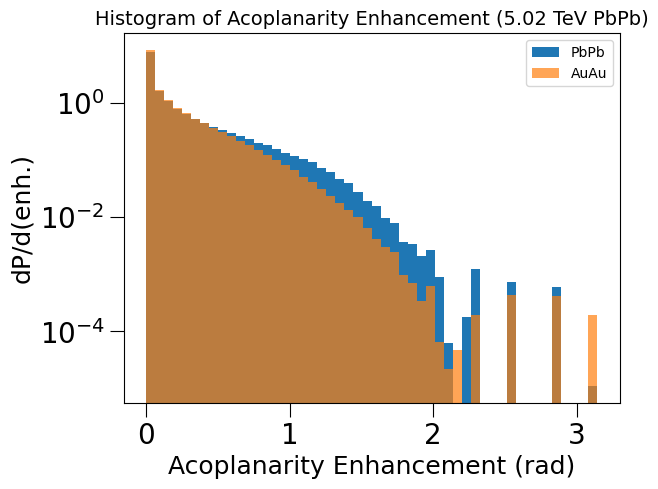

In [56]:
fig, axis = plt.subplots(1)
axis.set_title(r'Histogram of Acoplanarity Enhancement (5.02 TeV PbPb)', fontsize= 14) #^{hard}
axis.tick_params(axis='both',which='major',labelsize=20,length=10)

plt.hist(np.pi-pbpb['aco'], weights=pbpb['weight'], bins=50, density=True, label='PbPb') 
# plt.hist(np.pi - results[results['pt_f'] < 10]['aco'], weights=results[results['pt_f'] < 10]['weight'], bins=50, density=True) 
plt.hist(np.pi-auau['aco'], weights=auau['weight'], bins=50, density=True, label='AuAu', alpha=0.7) 

plt.yscale('log')
plt.legend()
plt.xlabel(r'Acoplanarity Enhancement (rad)', fontsize= 18)
plt.ylabel(r'dP/d(enh.)', fontsize= 18)
plt.savefig("aco_enh_hist_PbPb_LHC_5.02TeV_vs_AuAu_RHIC_200GeV_v1.1.0.png", bbox_inches="tight")

In [69]:
# fig, axis = plt.subplots(1)
# axis.set_title(r'Histogram of Acoplanarity Enhancement', fontsize= 18) #^{hard}
# axis.tick_params(axis='both',which='major',labelsize=20,length=10)

# plt.hist(np.pi-results['aco'], weights=results['weight'], bins=50, density=True) #[results['K_F_DRIFT'] == 0.75] 
# # plt.hist(np.pi - results[results['pt_f'] < 10]['aco'], weights=results[results['pt_f'] < 10]['weight'], bins=50, density=True) 

# plt.yscale('log')
# plt.xlabel(r'Acoplanarity Enhancement (rad)', fontsize= 18)
# plt.ylabel(r'dP/d(enh.)', fontsize= 18)
# # plt.savefig("aco_enh_hist_pt<10GeV_PbPb_LHC_5.02TeV.png", bbox_inches="tight")

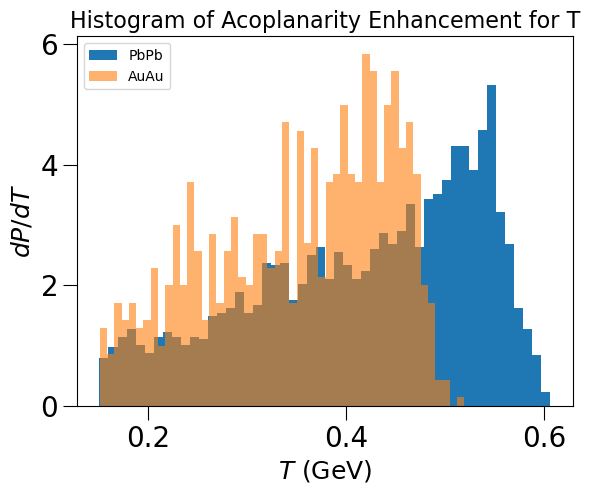

In [58]:
fig, axis = plt.subplots(1)
axis.set_title(r'Histogram of Acoplanarity Enhancement for T', fontsize= 16) #^{hard}

plt.hist(pbpb['Tmax_event'], bins=50, density=True, label='PbPb') #[results['K_F_DRIFT'] == 0.75] 
plt.hist(auau['Tmax_event'], bins=50, density=True, label='AuAu', alpha=0.6) #[results['K_F_DRIFT'] == 0.75] 

plt.xlabel(r'$T$ (GeV)', fontsize= 18)
plt.ylabel(r'$dP/dT$', fontsize= 18)
axis.tick_params(axis='both',which='major',labelsize=20,length=10)
# plt.yscale('log')
plt.legend()
plt.savefig("aco_enh_hist_T_PbPb_LHC_5.02TeV_vs_AuAu_RHIC_200GeV_v1.1.0.png", bbox_inches="tight")

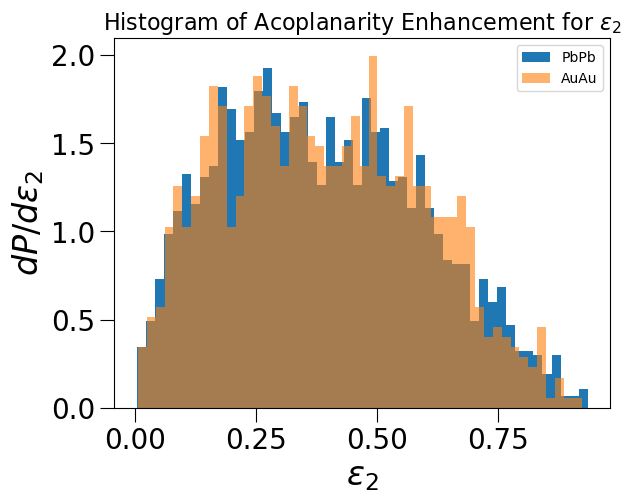

In [60]:
fig, axis = plt.subplots(1)
axis.set_title(r'Histogram of Acoplanarity Enhancement for $\epsilon_2$', fontsize= 16) #^{hard}

plt.hist(pbpb['e2'], bins=50, density=True, label='PbPb') #[results['K_F_DRIFT'] == 0.75]
plt.hist(auau['e2'], bins=50, density=True, label='AuAu', alpha=0.6) #[results['K_F_DRIFT'] == 0.75]

axis.tick_params(axis='both',which='major',labelsize=20,length=10)
plt.xlabel(r'$\epsilon_2$', fontsize= 24)
plt.ylabel(r'$dP/d\epsilon_2$', fontsize= 24)
plt.legend()

plt.savefig("aco_enh_hist_e2_PbPb_LHC_5.02TeV_vs_AuAu_RHIC_200GeV_v1.1.0.png", bbox_inches="tight")

In [43]:
# plt.hist(results['cent_10'], bins=50, density=True)
# plt.xlabel(r'$\%cent$')
# plt.ylabel(r'$dP/d\%cent$')

In [13]:
# plt.hist(pbpb['v2'], bins=50, density=True) #[results['K_F_DRIFT'] == 0.75]
# plt.xlabel(r'$v_2^{soft}$')
# plt.ylabel(r'$dP/dv_2^{soft}$')

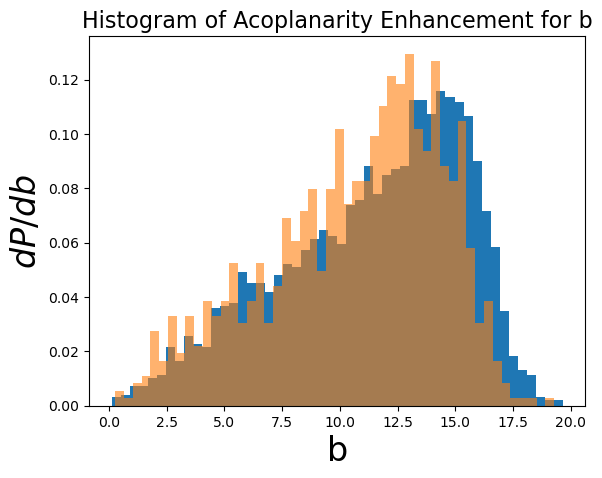

In [62]:
fig, axis = plt.subplots(1)

plt.hist(pbpb['b'], bins=50, density=True, label='PbPb')  #[results['K_F_DRIFT'] == 0.75]
plt.hist(auau['b'], bins=50, density=True, label='AuAu', alpha=0.6) #[results['K_F_DRIFT'] == 0.75]

axis.set_title(r'Histogram of Acoplanarity Enhancement for b', fontsize= 16)
plt.xlabel(r'b', fontsize= 24)
plt.ylabel(r'$dP/db$', fontsize= 24)
plt.savefig("aco_enh_hist_b_PbPb_LHC_5.02TeV_vs_AuAu_RHIC_200GeV_v1.1.0.png", bbox_inches="tight")

# Binned Acoplanarities 

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

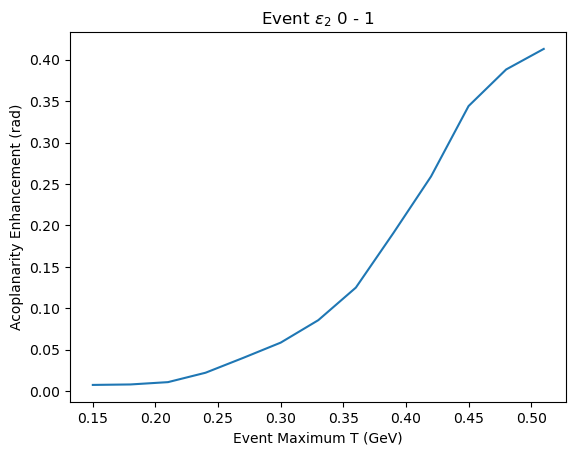

In [87]:
#Acoplanarities as a function of T (added Drift selection cut ) (AuAu)
e_min = 0
e_max = 1

e2_cut_auau = (auau['e2'] < e_max) & (auau['e2'] > e_min) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut_auau = (auau["pt_f"] < pt_max) & (auau["pt_f"] >= pt_min)

bin_width = 0.03
values0auau = np.array([])
T_bins = np.arange(0, 1, bin_width)
for T in T_bins:
    T_cut_auau = (auau['Tmax_event'] < T + bin_width/2) & (auau['Tmax_event'] > T - bin_width/2)
    # print("begin")
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(auau[e2_cut_auau & T_cut_auau & pt_cut_auau]['aco'], weights=auau[e2_cut_auau & T_cut_auau & pt_cut_auau]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])

    # print(results[e2_cut & T_cut]['aco'])
    # print("end")
    values0auau = np.append(values0auau, val)

fig, axis = plt.subplots(1)
axis.plot(T_bins, np.pi-values0auau)


#plt.ylim(0,0.085)
axis.set_title(r'Event $\epsilon_2$ {} - {}'.format(e_min, e_max))
axis.set_xlabel('Event Maximum T (GeV)')
axis.set_ylabel('Acoplanarity Enhancement (rad)')
# print(T_bins, values)

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

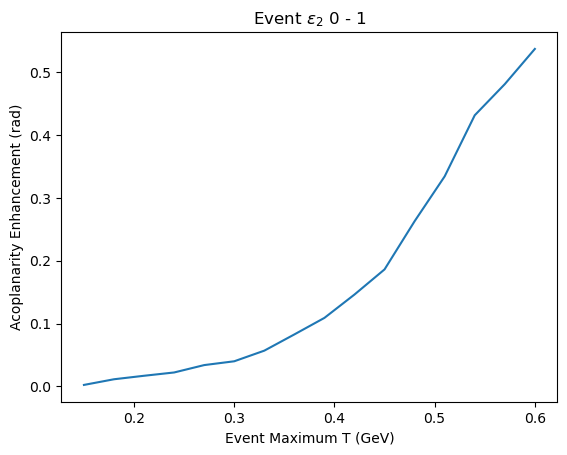

In [88]:
#Acoplanarities as a function of T (added Drift selection cut )
e_min = 0
e_max = 1

e2_cut = (pbpb['e2'] < e_max) & (pbpb['e2'] > e_min) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.03
values0 = np.array([])
T_bins = np.arange(0, 1, bin_width)
for T in T_bins:
    T_cut = (pbpb['Tmax_event'] < T + bin_width/2) & (pbpb['Tmax_event'] > T - bin_width/2)
    # print("begin")
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])

    # print(results[e2_cut & T_cut]['aco'])
    # print("end")
    values0 = np.append(values0, val)

fig, axis = plt.subplots(1)
axis.plot(T_bins, np.pi-values0)


#plt.ylim(0,0.085)
axis.set_title(r'Event $\epsilon_2$ {} - {}'.format(e_min, e_max))
axis.set_xlabel('Event Maximum T (GeV)')
axis.set_ylabel('Acoplanarity Enhancement (rad)')
# print(T_bins, values)

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

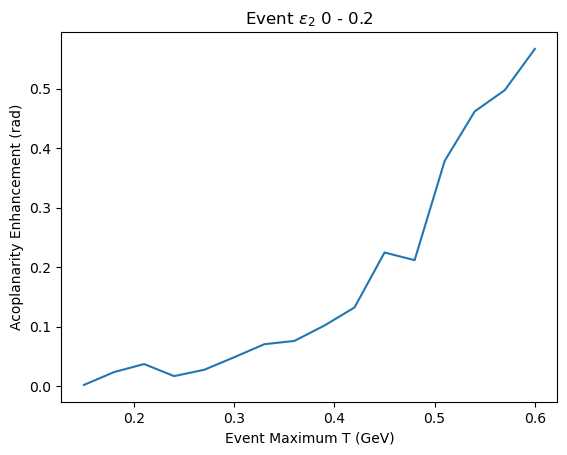

In [68]:
#Acoplanarities as a function of T (added Drift selection cut )
e_min = 0
e_max = 0.2

e2_cut = (pbpb['e2'] < e_max) & (pbpb['e2'] > e_min) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.03
values1 = np.array([])
T_bins = np.arange(0, 1, bin_width)
for T in T_bins:
    T_cut = (pbpb['Tmax_event'] < T + bin_width/2) & (pbpb['Tmax_event'] > T - bin_width/2)
    # print("begin")
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    # print(results[e2_cut & T_cut]['aco'])
    # print("end")
    values1 = np.append(values1, val)

fig, axis = plt.subplots(1)
axis.plot(T_bins, np.pi-values1)


# plt.ylim(0,0.085)
axis.set_title(r'Event $\epsilon_2$ {} - {}'.format(e_min, e_max))
axis.set_xlabel('Event Maximum T (GeV)')
axis.set_ylabel('Acoplanarity Enhancement (rad)')
# print(T_bins, values)

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

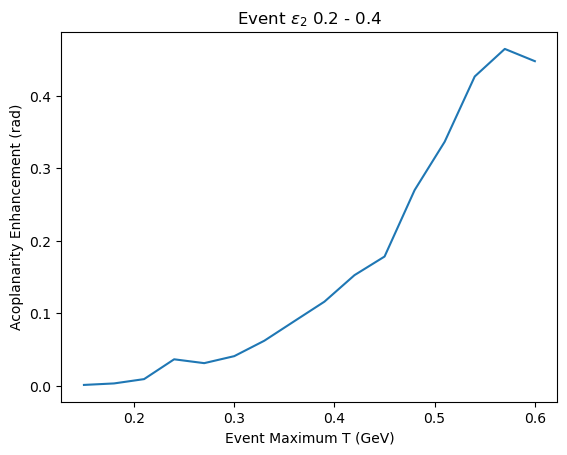

In [69]:
#Acoplanarities as a function of T (added Drift selection cut )
e_min = 0.2
e_max = 0.4

e2_cut = (pbpb['e2'] < e_max) & (pbpb['e2'] > e_min) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.03
values2 = np.array([])
T_bins = np.arange(0, 1, bin_width)
for T in T_bins:
    T_cut = (pbpb['Tmax_event'] < T + bin_width/2) & (pbpb['Tmax_event'] > T - bin_width/2)
    # print("begin")
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    # print(results[e2_cut & T_cut]['aco'])
    # print("end")
    values2 = np.append(values2, val)

fig, axis = plt.subplots(1)
axis.plot(T_bins, np.pi-values2)


# plt.ylim(0,0.085)
axis.set_title(r'Event $\epsilon_2$ {} - {}'.format(e_min, e_max))
axis.set_xlabel('Event Maximum T (GeV)')
axis.set_ylabel('Acoplanarity Enhancement (rad)')
# print(T_bins, values)

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

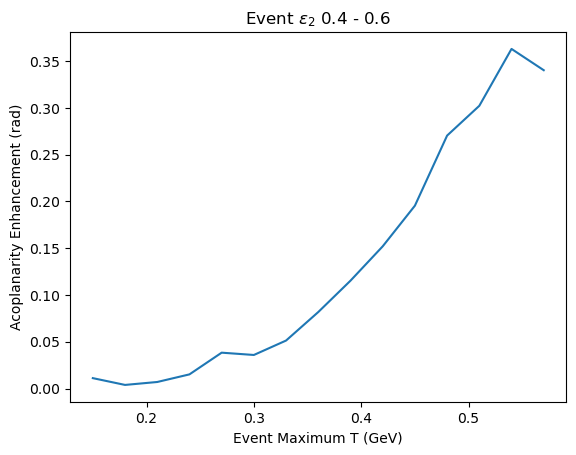

In [72]:
#Acoplanarities as a function of T (added Drift selection cut )
e_min = 0.4
e_max = 0.6

e2_cut = (pbpb['e2'] < e_max) & (pbpb['e2'] > e_min) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.03
values3 = np.array([])
T_bins = np.arange(0, 1, bin_width)
for T in T_bins:
    T_cut = (pbpb['Tmax_event'] < T + bin_width/2) & (pbpb['Tmax_event'] > T - bin_width/2)
    # print("begin")
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    # print(results[e2_cut & T_cut]['aco'])
    # print("end")
    values3 = np.append(values3, val)

fig, axis = plt.subplots(1)
axis.plot(T_bins, np.pi-values3)


# plt.ylim(0,0.085)
axis.set_title(r'Event $\epsilon_2$ {} - {}'.format(e_min, e_max))
axis.set_xlabel('Event Maximum T (GeV)')
axis.set_ylabel('Acoplanarity Enhancement (rad)')
# print(T_bins, values)

[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39
 0.42 0.45 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.75 0.78 0.81
 0.84 0.87 0.9  0.93 0.96 0.99] [       nan        nan        nan        nan        nan 3.14158366
 3.13984353 3.13197931 3.12901453 3.10511697 3.10402597 3.08791744
 3.06089816 3.04348376 3.00675708 2.98190792 2.9099448  2.86035992
 2.86330907        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]


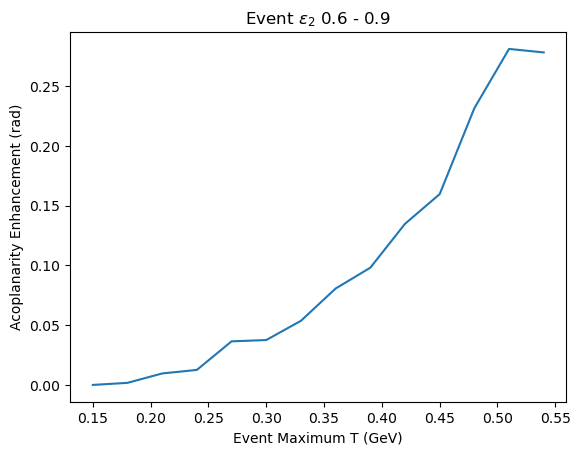

In [73]:
#Acoplanarities as a function of T (added Drift selection cut )
e_min = 0.6
e_max = 0.9

e2_cut = (pbpb['e2'] < e_max) & (pbpb['e2'] > e_min) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.03
values4 = np.array([])
T_bins = np.arange(0, 1, bin_width)
for T in T_bins:
    T_cut = (pbpb['Tmax_event'] < T + bin_width/2) & (pbpb['Tmax_event'] > T - bin_width/2)
    # print("begin")
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan    # print(results[e2_cut & T_cut]['aco']) #mean
    # print("end")
    values4 = np.append(values4, val)

fig, axis = plt.subplots(1)
axis.plot(T_bins, np.pi-values4)


#plt.ylim(0,0.085)
axis.set_title(r'Event $\epsilon_2$ {} - {}'.format(e_min, e_max))
axis.set_xlabel('Event Maximum T (GeV)')
axis.set_ylabel('Acoplanarity Enhancement (rad)')
print(T_bins, values4)

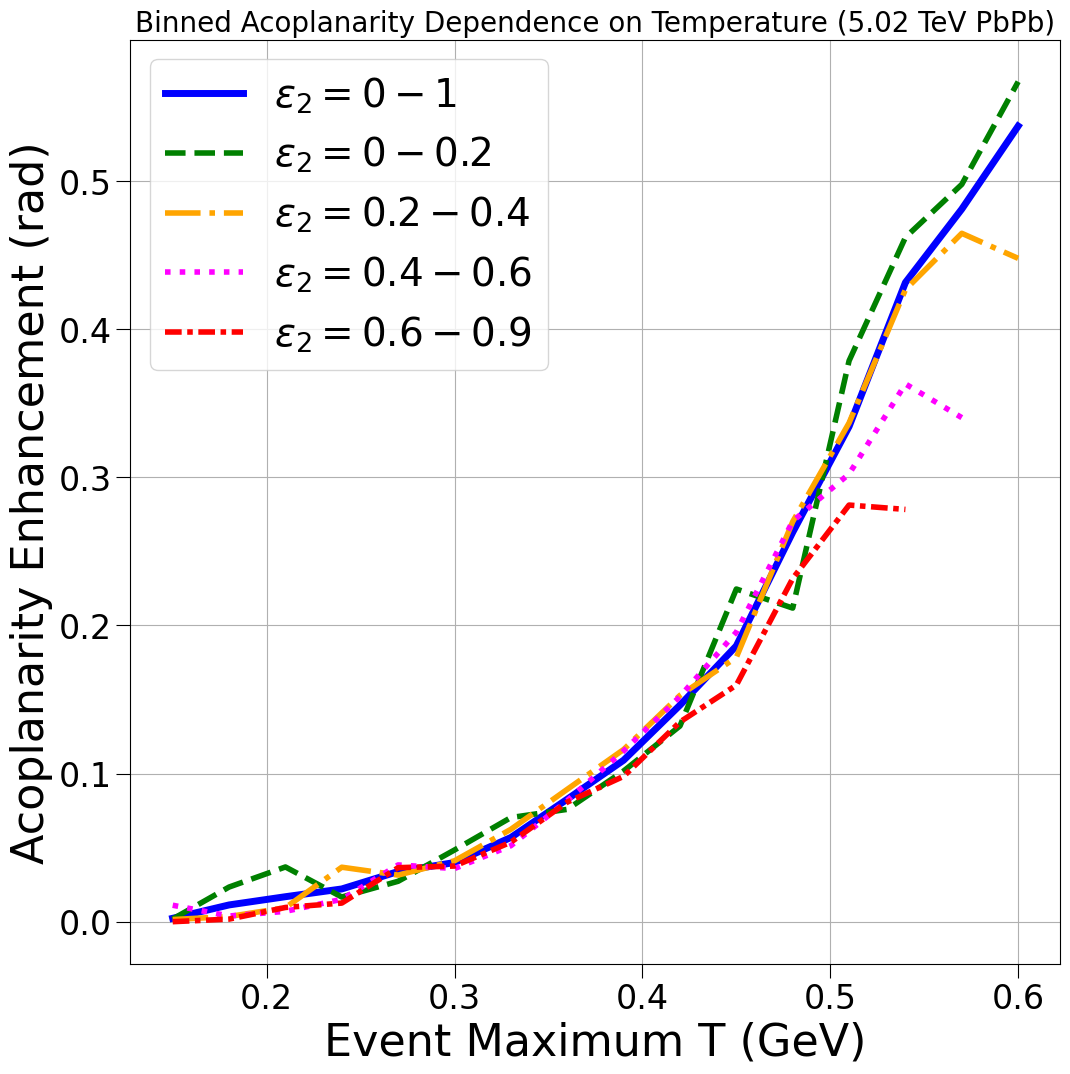

In [74]:
#Acoplanarity = func(T) Plot


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# #TeX up labels and text:

# plt.rc("text", usetex=True)
# plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
# plt.rc('font', size=24) 
# plt.rc('font', family='serif')

# #     matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
# plt.rcParams["font.weight"] = "bold"     
# #     plt.rcParams["axes.labelweight"] = "bold"
# plt.rc('axes', linewidth=2)



ax.set_title(r'Binned Acoplanarity Dependence on Temperature (5.02 TeV PbPb)', fontsize= 20)
ax.set_xlabel('Event Maximum T (GeV)', fontsize= 32)
ax.set_ylabel('Acoplanarity Enhancement (rad)', fontsize= 32)

ax.plot(T_bins, np.pi-values0, linewidth = 5, color='b', label="$\epsilon_2 = 0 - 1$") #
ax.plot(T_bins, np.pi-values1, linewidth = 4, color='g', ls= 'dashed', label="$\epsilon_2 = 0 - 0.2$") #
ax.plot(T_bins, np.pi-values2, linewidth = 4, color='orange', ls= 'dashdot', label="$\epsilon_2 = 0.2 - 0.4$") #
ax.plot(T_bins, np.pi-values3, linewidth = 4, color='magenta', ls= 'dotted', label="$\epsilon_2 = 0.4 - 0.6$") #
ax.plot(T_bins, np.pi-values4, linewidth = 4, color='r', ls= (0,(3,1,1,1)), label="$\epsilon_2 = 0.6 - 0.9$") #

ax.tick_params(axis='both',which='major',labelsize=24,length=10)
# plt.ylim(0,0.09)
ax.grid()
ax.legend(fontsize=28)

# plt.savefig("aco_enh_weighted_funcT_ecc2_all_PbPb_LHC_5.02TeV.png", bbox_inches="tight")
# plt.savefig("aco_enh_weighted_funcT_pT<10GeV_ecc2_all_PbPb_LHC_5.02TeV_v1.1.0.png", bbox_inches="tight")

# plt.savefig("aco_enh_weighted_funcT_ecc2_0to1.png", bbox_inches="tight")
# ax.set_xlim(0,500)
# print(T_bins, values)

In [ ]:
#Acoplanarity = func(T) Plot


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.set_title(r'Acoplanarity Dependence on Temperature (AuAu vs PbPb)', fontsize= 20)
ax.set_xlabel('Event Maximum T (GeV)', fontsize= 32)
ax.set_ylabel('Acoplanarity Enhancement (rad)', fontsize= 32)

ax.plot(T_bins, np.pi-values0, linewidth = 5, color='g', label="PbPb") #
ax.plot(T_bins, np.pi-values0auau, linewidth = 5, color='o', label="AuAu") #
# ax.plot(T_bins, np.pi-values1, linewidth = 4, color='g', ls= 'dashed', label="$\epsilon_2 = 0 - 0.2$") #
# ax.plot(T_bins, np.pi-values2, linewidth = 4, color='orange', ls= 'dashdot', label="$\epsilon_2 = 0.2 - 0.4$") #
# ax.plot(T_bins, np.pi-values3, linewidth = 4, color='magenta', ls= 'dotted', label="$\epsilon_2 = 0.4 - 0.6$") #
# ax.plot(T_bins, np.pi-values4, linewidth = 4, color='r', ls= (0,(3,1,1,1)), label="$\epsilon_2 = 0.6 - 0.9$") #

ax.tick_params(axis='both',which='major',labelsize=24,length=10)
# plt.ylim(0,0.09)
ax.grid()
ax.legend(fontsize=28)

# plt.savefig("aco_enh_weighted_funcT_ecc2_all_PbPb_LHC_5.02TeV.png", bbox_inches="tight")
# plt.savefig("aco_enh_weighted_funcT_pT<10GeV_ecc2_all_PbPb_LHC_5.02TeV_v1.1.0.png", bbox_inches="tight")

# plt.savefig("aco_enh_weighted_funcT_ecc2_0to1.png", bbox_inches="tight")
plt.savefig("aco_enh_weighted_funcT_AuAu_vs_PbPb_ecc2_0to1.png", bbox_inches="tight")

# ax.set_xlim(0,500)
# print(T_bins, values)

[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.78
 0.84 0.9  0.96] [2.89049497 2.86882305 2.82816276 2.83977546 2.86973026 2.8745325
 2.90814318 2.94632848 2.96152157 2.99278893 2.99853704 3.05296286
 3.05406996 3.06724853 3.08456213 3.10635946 3.12396494]
(17,)
(17,)


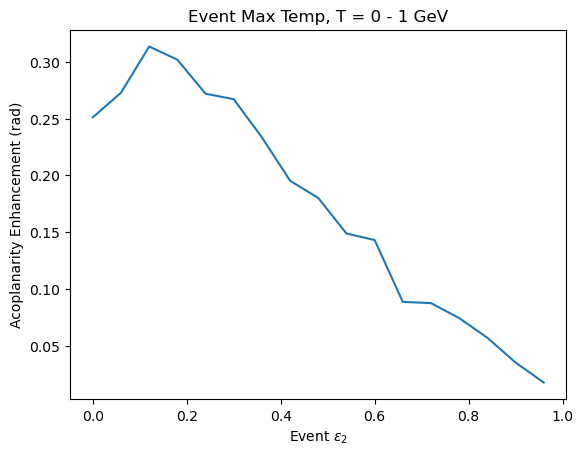

In [75]:
#Aco = func(e_2)

t_min = 0 #GeV
t_max = 1 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values5 = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values5 = np.append(values5, val)

fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values5)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

print(e2_bins, values5)
print(np.shape(e2_bins))
print(np.shape(values5))

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

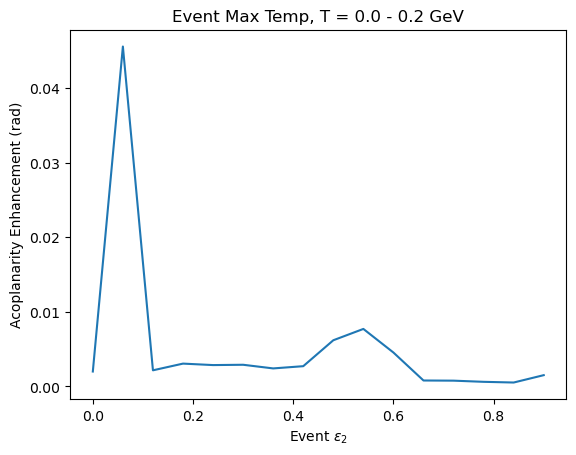

In [76]:
t_min = 0.0 #GeV
t_max = 0.2 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values6 = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values6 = np.append(values6, val)

fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values6)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

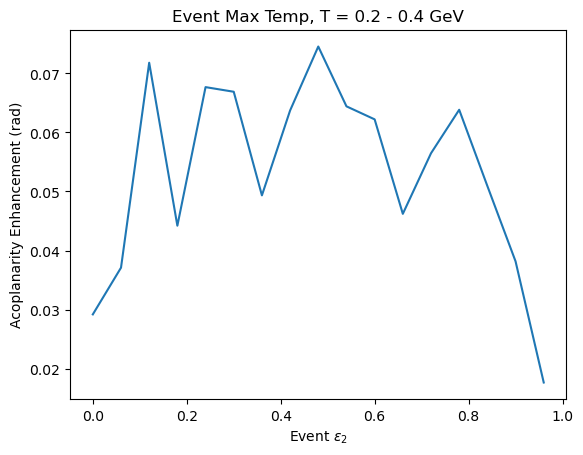

In [77]:
t_min = 0.2 #GeV
t_max = 0.4 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values7 = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values7 = np.append(values7, val)


fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values7)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

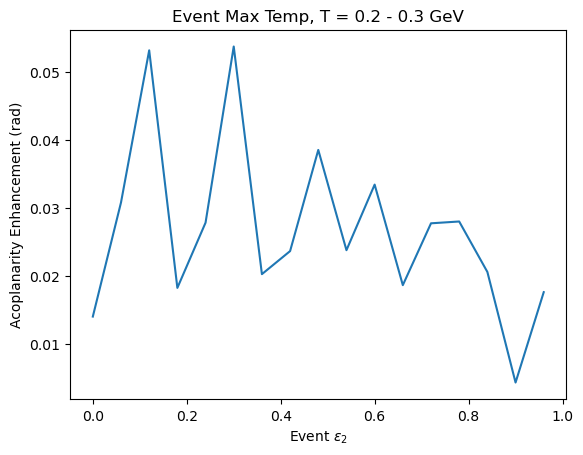

In [78]:
t_min = 0.2 #GeV
t_max = 0.3 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values7a = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values7a = np.append(values7a, val)


fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values7a)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

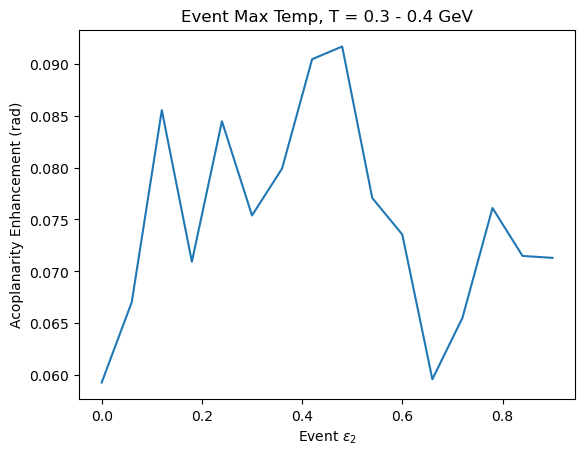

In [79]:
t_min = 0.3 #GeV
t_max = 0.4 #GeV
T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values7b = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values7b = np.append(values7b, val)


fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values7b)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.78
 0.84 0.9  0.96] [2.62742313 2.6943945  2.71399707 2.73376004 2.7775438  2.79870249
 2.8347838  2.86210302 2.90005728 2.93074277 2.92305894 2.98087469
 2.99252427 2.9983017  2.9967563  3.05294157        nan]
(17,)
(17,)


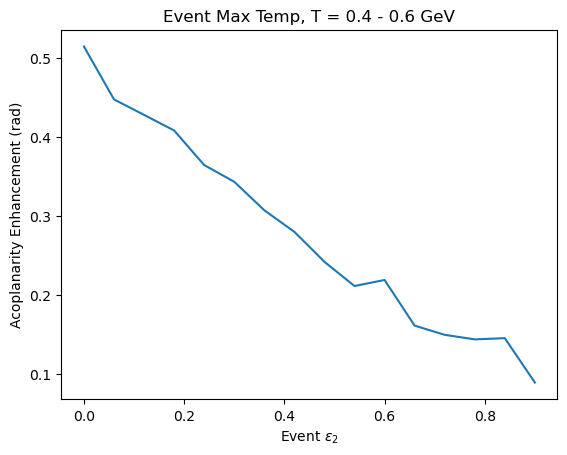

In [80]:
t_min = 0.4 #GeV
t_max = 0.6 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values8 = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values8 = np.append(values8, val)


fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values8)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

print(e2_bins, values8)
print(np.shape(e2_bins))
print(np.shape(values8))

[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.78
 0.84 0.9  0.96] [2.97649055 2.91730453 2.96885027 2.90528499 2.9430341  2.91418035
 2.90442103 2.89908286 2.92500212 2.94806468 2.93495774 2.98839819
 2.99252427 2.9983017  2.9967563  3.05294157        nan]
(17,)
(17,)


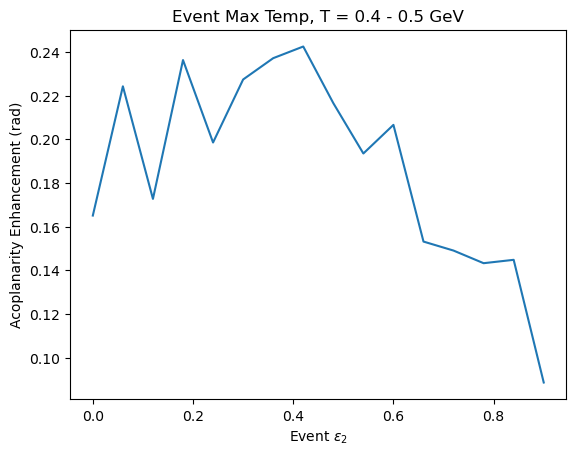

In [81]:
t_min = 0.4 #GeV
t_max = 0.5 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values8a = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values8a = np.append(values8a, val)


fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values8a)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

print(e2_bins, values8a)
print(np.shape(e2_bins))
print(np.shape(values8a))

[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.78
 0.84 0.9  0.96] [2.54442301 2.65872443 2.67090271 2.7017219  2.72179525 2.741597
 2.76615464 2.79317748 2.80846233 2.84962789 2.82645769 2.92926794
        nan        nan        nan        nan        nan]
(17,)
(17,)


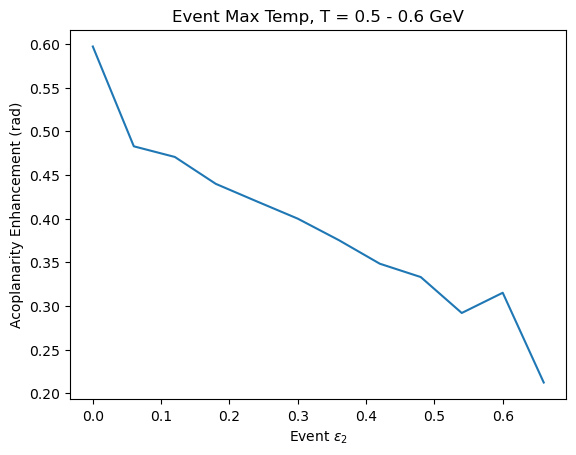

In [82]:
t_min = 0.5 #GeV
t_max = 0.6 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values8b = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values8b = np.append(values8b, val)


fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values8b)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

print(e2_bins, values8b)
print(np.shape(e2_bins))
print(np.shape(values8b))

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

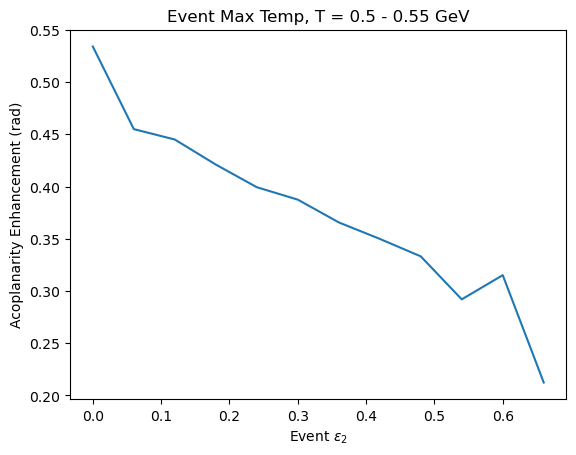

In [83]:
t_min = 0.5 #GeV
t_max = 0.55 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values8ba = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values8ba = np.append(values8ba, val)


fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values8ba)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

# print(e2_bins, values8ba)
# print(np.shape(e2_bins))
# print(np.shape(values8b))

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

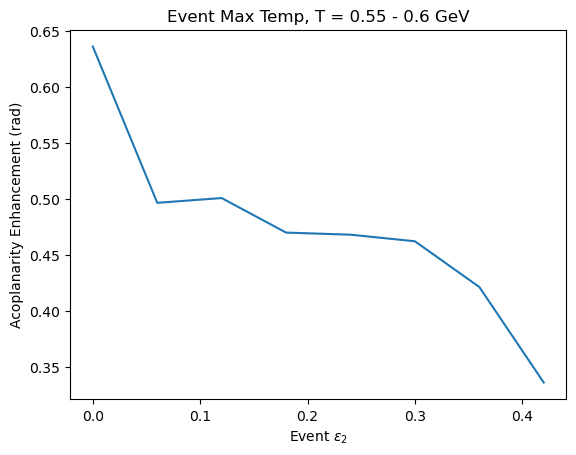

In [84]:
t_min = 0.55 #GeV
t_max = 0.6 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values8bb = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values8bb = np.append(values8bb, val)


fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values8bb)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

# print(e2_bins, values8ba)
# print(np.shape(e2_bins))
# print(np.shape(values8b))

Text(0, 0.5, 'Acoplanarity Enhancement (rad)')

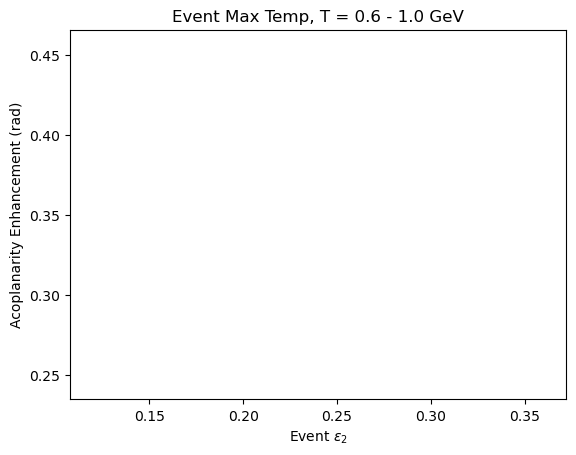

In [85]:
t_min = 0.6 #GeV
t_max = 1.0 #GeV

T_cut = (pbpb['Tmax_event'] > t_min) & (pbpb['Tmax_event'] < t_max) #& (results['K_F_DRIFT'] == 0.75)

# Define pt cuts (2-5 GeV is the region of confidence)
pt_min = 0 
pt_max = 10
 
# Create pt mask
pt_cut = (pbpb["pt_f"] < pt_max) & (pbpb["pt_f"] >= pt_min)

bin_width = 0.06

values9 = np.array([])
e2_bins = np.arange(0, 1, bin_width)
for e2 in e2_bins:
    e2_cut = (pbpb['e2'] < e2 + bin_width/2) & (pbpb['e2'] > e2 - bin_width/2)
    try:
        # val = np.average(results[e2_cut & T_cut & pt_cut]['aco'], weights=results[e2_cut & T_cut & pt_cut]['weight'])
        val = np.average(pbpb[e2_cut & T_cut & pt_cut]['aco'], weights=pbpb[e2_cut & T_cut & pt_cut]['weight'])
    except:
        val = np.nan
    
    # val = np.mean(results[e2_cut & T_cut]['aco'])
    values9 = np.append(values9, val)


fig, axis = plt.subplots(1)
axis.plot(e2_bins, np.pi-values9)

# plt.ylim(0,0.08)
axis.set_title(r'Event Max Temp, T = {} - {} GeV'.format(t_min, t_max)) 
axis.set_xlabel(r'Event $\epsilon_2$')
axis.set_ylabel('Acoplanarity Enhancement (rad)')

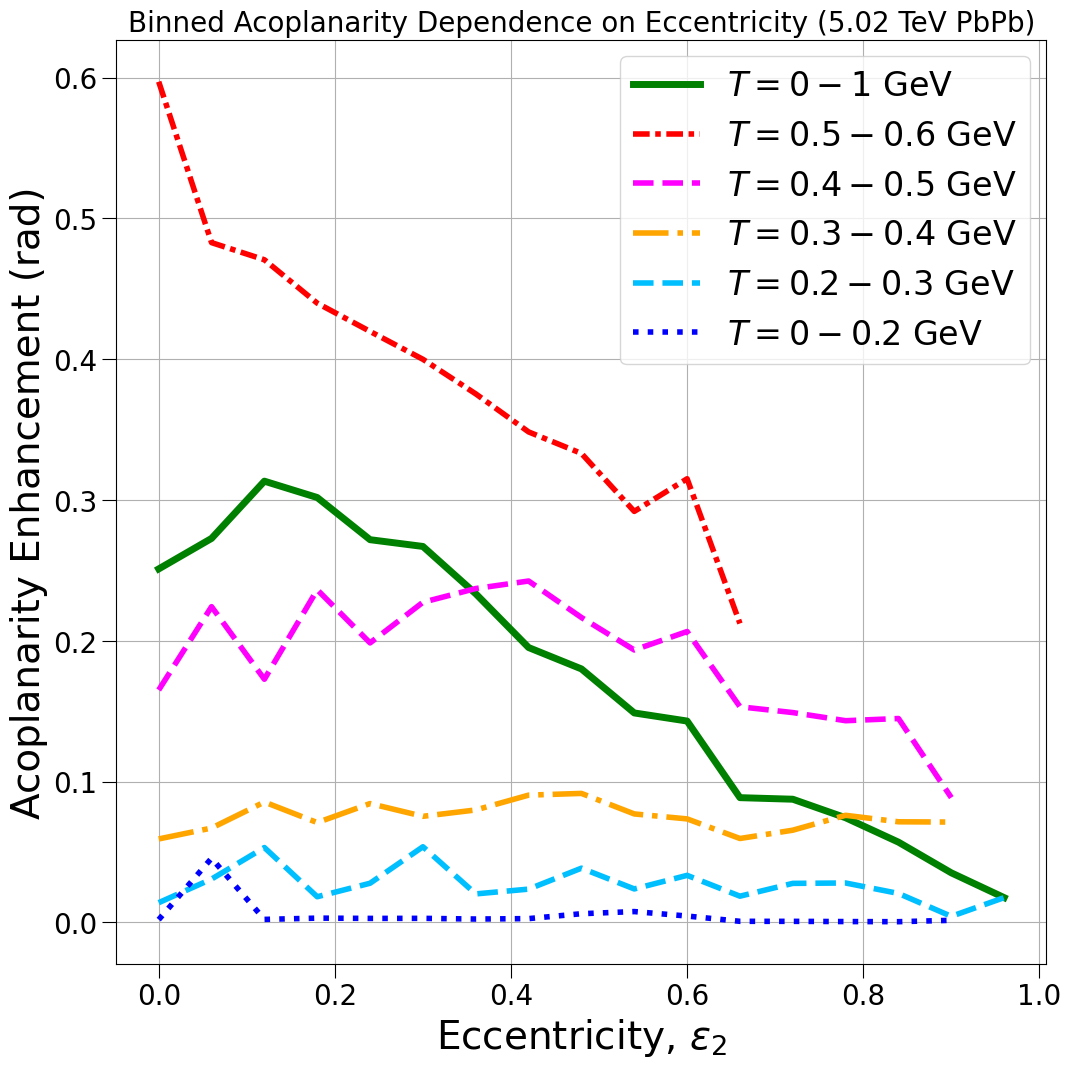

In [86]:
#Acoplanarity = func(e2) Plot


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# #TeX up labels and text:

# plt.rc("text", usetex=True)
# plt.rcParams['text.latex.preamble'] = r'\usepackage{graphicx}'
# plt.rc('font', size=24) 
# plt.rc('font', family='serif')

# #     matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
# plt.rcParams["font.weight"] = "bold"     
# #     plt.rcParams["axes.labelweight"] = "bold"
# plt.rc('axes', linewidth=2)



ax.set_title(r'Binned Acoplanarity Dependence on Eccentricity (5.02 TeV PbPb)', fontsize= 20)
ax.set_xlabel('Eccentricity, $\epsilon_2$', fontsize= 28)
ax.set_ylabel('Acoplanarity Enhancement (rad)', fontsize= 28)

ax.plot(e2_bins, np.pi-values5, linewidth = 5, color='g', label="$T = 0 - 1$ GeV") #

ax.plot(e2_bins, np.pi-values8b, linewidth = 4, color='r', ls= (0,(3,1,1,1)), label="$T = 0.5 - 0.6$ GeV") #
# ax.plot(e2_bins, np.pi-values8bb, linewidth = 4, color='purple', ls= (0,(5,1)), label="$T = 0.55 - 0.6$ GeV") #
# ax.plot(e2_bins, np.pi-values8ba, linewidth = 4, color='r', ls= (0,(3,1,1,1)), label="$T = 0.5 - 0.55$ GeV") #

ax.plot(e2_bins, np.pi-values8a, linewidth = 4, color='magenta', ls= 'dashed', label="$T = 0.4 - 0.5$ GeV") #
ax.plot(e2_bins, np.pi-values7b, linewidth = 4, color='orange', ls= 'dashdot', label="$T = 0.3 - 0.4$ GeV") #
ax.plot(e2_bins, np.pi-values7a, linewidth = 4, color='deepskyblue', ls= '--', label="$T = 0.2 - 0.3$ GeV") #
ax.plot(e2_bins, np.pi-values6, linewidth = 4, color='b', ls= 'dotted', label="$T = 0 - 0.2$ GeV") #

# ax.plot(e2_bins, np.pi-values9, linewidth = 4, color='r', ls= (0,(3,1,1,1)), label="$T = 0.6 - 1$ GeV") #

ax.tick_params(axis='both',which='major',labelsize=20,length=10)
# plt.ylim(0,0.08)
ax.grid()
ax.legend(fontsize=24)

# plt.savefig("aco_enh_weighted_funcecc2_Tmax_all_PbPb_LHC_5.02TeV.png", bbox_inches="tight")

# plt.savefig("aco_enh_weighted_funcecc2_pT<10GeV_Tmax_all_PbPb_LHC_5.02TeV_v1.1.0.png", bbox_inches="tight")

# plt.savefig("aco_enh_weighted_funcecc2_Tmax_0to1.png", bbox_inches="tight")

# ax.set_xlim(0,500)
# print(T_bins, values)